In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import kerastuner as kt

# Ensure keras-tuner is upgraded
!pip install keras-tuner --upgrade --quiet

In [3]:
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

x = df.drop('Diabetes_binary', axis=1) #All Featutes - Target Var
y = df['Diabetes_binary'] # Target Var

# Standardize the features
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import kerastuner as kt

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_dim=x_train.shape[1]))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize Keras Tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir', project_name='diabetes_nn_tuning')

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of units in the first layer is {best_hps.get('units')} and in the second layer is {best_hps.get('units')}.")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

Trial 30 Complete [00h 00m 47s]
val_accuracy: 0.7532357573509216

Best val_accuracy So Far: 0.7554282546043396
Total elapsed time: 00h 11m 32s
The optimal number of units in the first layer is 64 and in the second layer is 64.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import kerastuner as kt
import numpy as np

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))

    # First layer - with flexible units and dropout
    model.add(Dense(hp.Int('units_1', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second layer - with flexible units and dropout
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Third layer - with flexible units and dropout
    model.add(Dense(hp.Int('units_3', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.4, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='finetune_dir',
    project_name='diabetes_nn_tuning'
)

# Search for the best hyperparameters
tuner.search(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print out the best hyperparameters
print("Best Hyperparameters:")
print(f"First layer units: {best_hps.get('units_1')}")
print(f"First layer dropout: {best_hps.get('dropout_1')}")
print(f"Second layer units: {best_hps.get('units_2')}")
print(f"Second layer dropout: {best_hps.get('dropout_2')}")
print(f"Third layer units: {best_hps.get('units_3')}")
print(f"Third layer dropout: {best_hps.get('dropout_3')}")
print(f"Optimizer: {best_hps.get('optimizer')}")

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Optional: Train the best model with all hyperparameters
history = model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
    ]
)

Trial 132 Complete [00h 00m 51s]
val_accuracy: 0.7518212199211121

Best val_accuracy So Far: 0.7554989457130432
Total elapsed time: 01h 01m 38s

Search: Running Trial #133

Value             |Best Value So Far |Hyperparameter
192               |224               |units_1
0.5               |0.1               |dropout_1
128               |112               |units_2
0.4               |0.4               |dropout_2
32                |64                |units_3
0.2               |0.1               |dropout_3
12                |4                 |tuner/epochs
4                 |2                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
2                 |1                 |tuner/round
0105              |0045              |tuner/trial_id

Epoch 5/12


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1768/1768 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7455 - loss: 0.5192 - val_accuracy: 0.7520 - val_loss: 0.5058
Epoch 6/12
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7459 - loss: 0.5183 - val_accuracy: 0.7513 - val_loss: 0.5031
Epoch 7/12
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7474 - loss: 0.5153 - val_accuracy: 0.7499 - val_loss: 0.5052
Epoch 8/12
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7488 - loss: 0.5158 - val_accuracy: 0.7514 - val_loss: 0.5032
Epoch 9/12
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7487 - loss: 0.5140 - val_accuracy: 0.7510 - val_loss: 0.5038
Epoch 10/12
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7459 - loss: 0.5139 - val_accuracy: 0.7488 - val_loss: 0.5030
Epoch 11/12
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7485 - loss: 0.5135 - val_accuracy: 0.7517 - val_loss: 0.5039
Epoch 12/12


KeyboardInterrupt: 

Epoch 1/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7211 - loss: 0.5657 - val_accuracy: 0.7488 - val_loss: 0.5061
Epoch 2/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7453 - loss: 0.5160 - val_accuracy: 0.7479 - val_loss: 0.5064
Epoch 3/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7483 - loss: 0.5116 - val_accuracy: 0.7478 - val_loss: 0.5072
Epoch 4/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7496 - loss: 0.5128 - val_accuracy: 0.7513 - val_loss: 0.5056
Epoch 5/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7479 - loss: 0.5105 - val_accuracy: 0.7491 - val_loss: 0.5047
Epoch 6/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7489 - loss: 0.5087 - val_accuracy: 0.7497 - val_loss: 0.5041
Epoch 7/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7509 - loss: 0.5109 - val_accuracy: 0.7515 - val_loss: 0.5056
Epoch 8/100
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7501 - loss: 

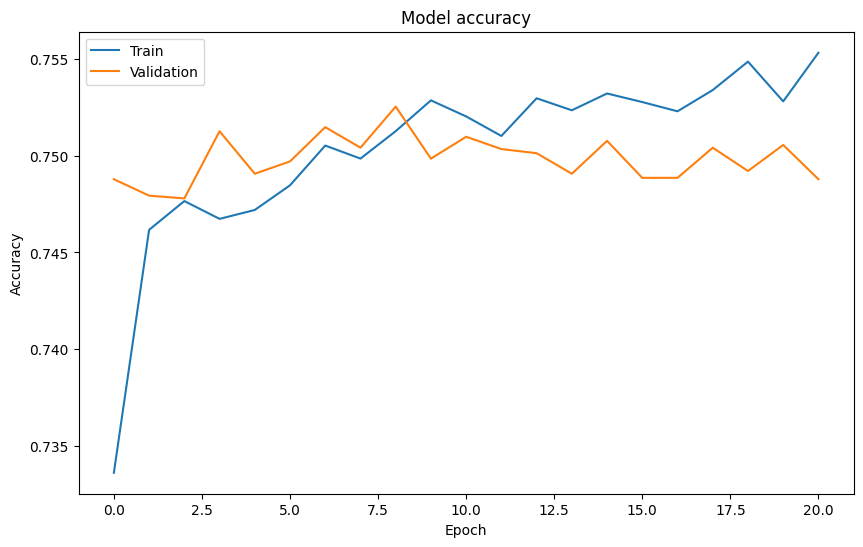

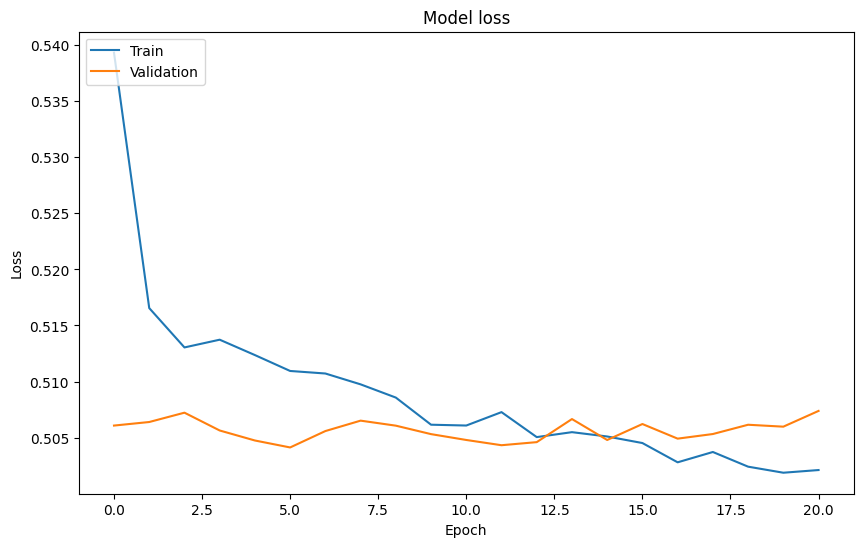

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt

# Define the Neural Network model
model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))
model.add(Dense(224, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(112, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
    ]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Neural Network Test Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt

# Define the Neural Network model
model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

Epoch 1/50
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7082 - loss: 0.5842 - val_accuracy: 0.7501 - val_loss: 0.5052 - learning_rate: 0.0010
Epoch 2/50
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7435 - loss: 0.5210 - val_accuracy: 0.7503 - val_loss: 0.5043 - learning_rate: 0.0010
Epoch 3/50
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7424 - loss: 0.5190 - val_accuracy: 0.7516 - val_loss: 0.5012 - learning_rate: 0.0010
Epoch 4/50
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7461 - loss: 0.5157 - val_accuracy: 0.7515 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 5/50
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7496 - loss: 0.5167 - val_accuracy: 0.7529 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 6/50
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7472 - loss: 0.5141 - val_accuracy: 0.7513 - val_loss: 0.5004 - learning_rate: 0.0010
Epoch 7/50
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7482 - 

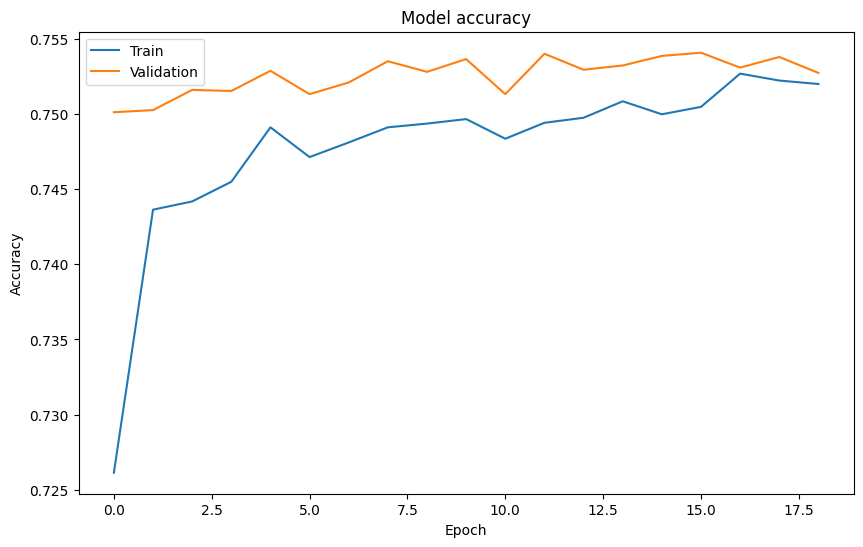

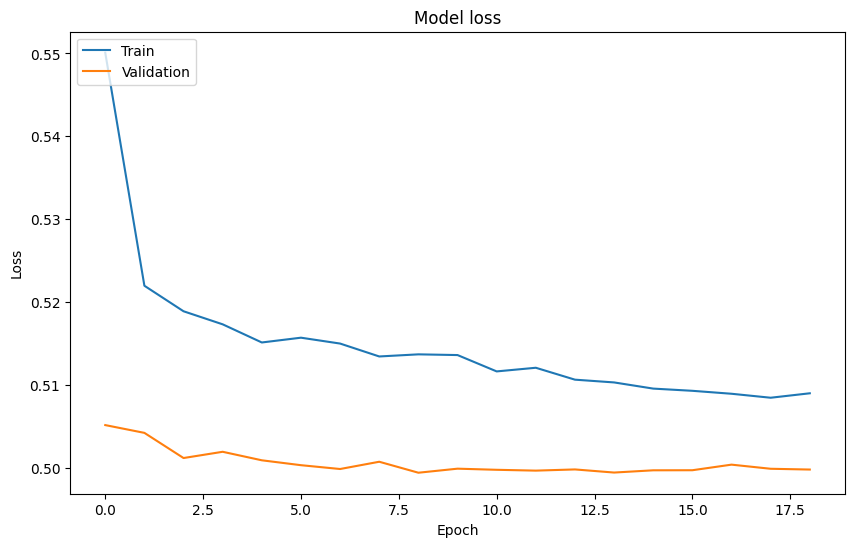

In [14]:
# Train the model with callbacks
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint, lr_scheduler])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Neural Network Test Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert x_train and x_test to DataFrames for feature names
feature_names = df.drop('Diabetes_binary', axis=1).columns
x_train_df = pd.DataFrame(x_train, columns=feature_names)
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Create a background dataset (subset of x_train)
background = x_train_df.sample(100, random_state=42).values

# Initialize the SHAP explainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(x_test_df.values)

# If shap_values is a list, take the first element (for binary classification)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [13]:
shap_values = np.squeeze(shap_values)

print(f"SHAP values shape after squeezing: {shap_values.shape}")

SHAP values shape after squeezing: (14139, 21)



Top 5 Most Important Features:
     Feature  Mean Absolute SHAP Value
13   GenHlth                  0.091017
3        BMI                  0.079692
0     HighBP                  0.060540
18       Age                  0.054276
1   HighChol                  0.050219


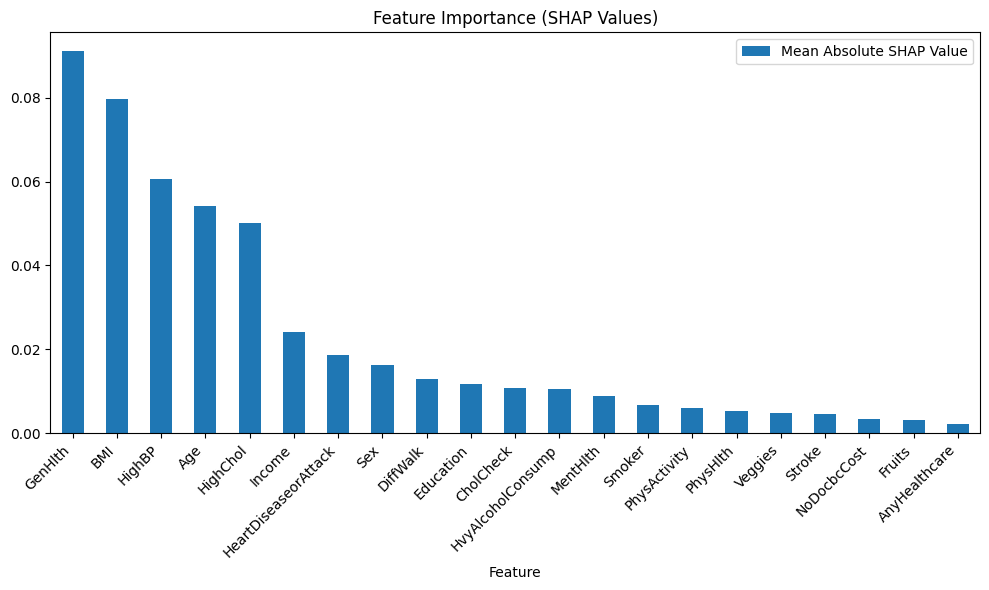

In [15]:
# Calculate mean absolute SHAP values for each feature
# Ensure shap_values is a 2D array: [samples x features]
if shap_values.ndim == 2:
    shap_importance = np.abs(shap_values).mean(axis=0)
else:
    raise ValueError("Unexpected SHAP values shape: ensure it's 2D (samples x features)")

# Convert to DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean Absolute SHAP Value': shap_importance
}).sort_values('Mean Absolute SHAP Value', ascending=False)

# Display the top 5 important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Plot feature importance
feature_importance.plot(
    x='Feature',
    y='Mean Absolute SHAP Value',
    kind='bar',
    figsize=(10, 6)
)
plt.title('Feature Importance (SHAP Values)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

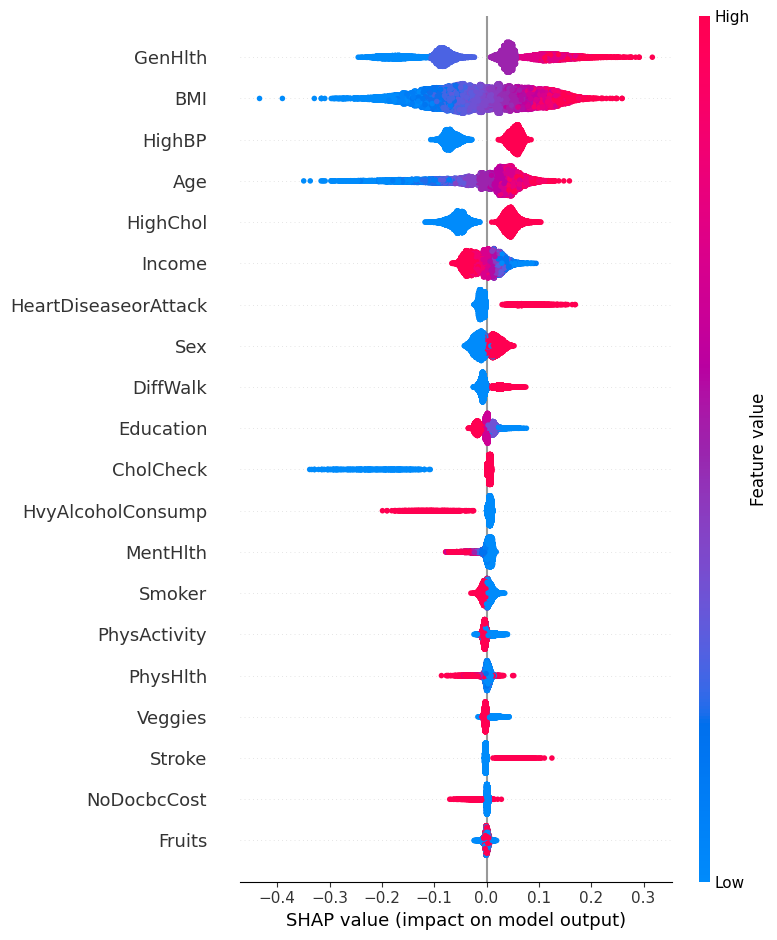

In [16]:
shap.summary_plot(shap_values, x_test, feature_names=feature_names)